In [114]:
import gzip
import json
import csv
from tqdm import tqdm
import gzip
import _pickle as cPickle
import sys
from urllib.request import urlopen, Request

import nltk
from nltk import ngrams

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/HotpotQA_2gram_distribution.pickle.gz


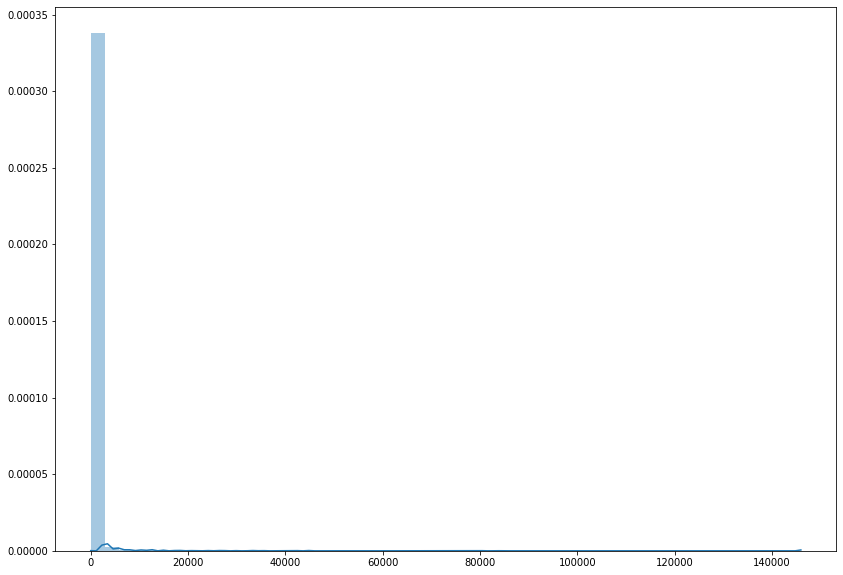

In [25]:

def get_gzip_pickle(file_url):
    print("Fetching: {}".format(file_url))
    with urlopen(Request(file_url,
                     headers={"Accept-Encoding": "gzip"})) as response, \
     gzip.GzipFile(fileobj=response) as myzip:
         unzip_pickle= cPickle.load(myzip)
    
    return unzip_pickle

foo = 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/HotpotQA_2gram_distribution.pickle.gz'
fdist_gz = get_gzip_pickle(foo)
plt.figure(figsize=(14,10))
ngram_freq = [freq for freq in fdist_gz.values() if freq > 100]
sns.distplot(ngram_freq);

In [27]:
distributions_2gram = {
    'SQuAD': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/SQuAD_2gram_distribution.pickle.gz',
    'NewsQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/NewsQA_2gram_distribution.pickle.gz',
    'HotpotQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/HotpotQA_2gram_distribution.pickle.gz',
    'SearchQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/SearchQA_2gram_distribution.pickle.gz',
    'TriviaQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/TriviaQA_2gram_distribution.pickle.gz',
    'NaturalQuestionsShort': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/NaturalQuestionsShort_2gram_distribution.pickle.gz',
}

distributions_3gram = {
    'SQuAD': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/SQuAD_3gram_distribution.pickle.gz',
    'NewsQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/NewsQA_3gram_distribution.pickle.gz',
    'HotpotQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/HotpotQA_3gram_distribution.pickle.gz',
    'SearchQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/SearchQA_3gram_distribution.pickle.gz',
    'TriviaQA': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/TriviaQA_3gram_distribution.pickle.gz',
    'NaturalQuestionsShort': 'https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/NaturalQuestionsShort_3gram_distribution.pickle.gz',
}



In [196]:
# Compare squad news
def old_score_distributions(source, target):
    shared_keys = 0
    differences = 0
    target_sum = sum(target.values())
    for k,v in source.items():
        if k in target:
            shared_keys += 1
            differences += abs(v - target[k])
            target_sum -= target[k]
        else:
            differences += v
    # Calculate Score
    total_keys = (len(source) + len(target)) - shared_keys
    sum_of_differences = differences + target_sum
    score = sum_of_differences/total_keys
    
    return score

def old2_score_distributions(source, target):
    shared_keys = 0
    differences = 0
    
    source_sum = sum(source.values())
    target_sum = sum(target.values())
    total_sum = source_sum + target_sum
    common_sum = 0
    
    for k,v in source.items():
        if k in target:
            shared_keys += 1
            differences += abs(v - target[k])
            common_sum += min(v, target[k])
        else:
            differences += v
    # Calculate Score common divided by mean size.
    score = common_sum/(total_sum/2)
    print(score)
    return score

def old3_score_distributions(source, target):
    shared_keys = 0
    differences = 0
    
    source_sum = sum(source.values())
    target_sum = sum(target.values())
    total_sum = source_sum + target_sum
    common_sum = 0
    
    for k,v in source.items():
        if k in target:
            shared_keys += 1
            differences += abs(v - target[k])
            common_sum += min(v, target[k])
        else:
            differences += v
    # Calculate Score common divided by target sum (pay for small predicting large).
    union_ratio = common_sum/total_sum
    ngram_ratio = source_sum/target_sum
    score_1 = union_ratio * ngram_ratio
    score_2 = common_sum/target_sum
    
    return union_ratio, ngram_ratio, score_1, score_2


def score_distributions(source, target):
    shared_keys = 0
    differences = 0
    
    source_sum = sum(source.values())
    target_sum = sum(target.values())
    total_sum = source_sum + target_sum
    common_sum = 0
    
    for k,v in source.items():
        if k in target:
            shared_keys += 1
            differences += abs(v - target[k])
            common_sum += min(v, target[k])
        else:
            differences += v
    # Calculate Score common divided by target sum (pay for small predicting large).
#     source_sum = source_sum
#     common_sum = common_sum
    score_1 = common_sum/source_sum
    score_2 = common_sum/target_sum
    
    return source_sum, common_sum, score_1, score_2

def cache_distribution(distributions):
    cached_distributions = {}
    for name,url in distributions.items():
        cached_distributions[name] = get_gzip_pickle(url)
    
    return cached_distributions 



In [57]:
cached_distributions_2gram = cache_distribution(distributions_2gram)

Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/SQuAD_2gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/NewsQA_2gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/HotpotQA_2gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/SearchQA_2gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/TriviaQA_2gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/NaturalQuestionsShort_2gram_distribution.pickle.gz


In [64]:
cached_distributions_3gram = cache_distribution(distributions_3gram)

Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/SQuAD_3gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/NewsQA_3gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/HotpotQA_3gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/SearchQA_3gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/TriviaQA_3gram_distribution.pickle.gz
Fetching: https://nlp-distribution.s3.ca-central-1.amazonaws.com/mrqa/distributions/NaturalQuestionsShort_3gram_distribution.pickle.gz


In [198]:

def run_scoring(cached_distributions):
    source_sum_final = []
    common_sum_final = []
    score_1_final = []
    score_2_final = []
    for source_name,source_distribution in cached_distributions.items():
        source_sum_line = []
        common_sum_line = []
        score_1_line = []
        score_2_line = []
        for target_name,target_distribution in cached_distributions.items():
            source_sum, common_sum, score_1, score_2 = score_distributions(source_distribution, target_distribution)
            
            source_sum_line.append(source_sum)
            common_sum_line.append(common_sum)
            score_1_line.append(score_1)
            score_2_line.append(score_2)

        source_sum_final.append(source_sum_line)
        common_sum_final.append(common_sum_line)
        score_1_final.append(score_1_line)
        score_2_final.append(score_2_line)
    
    return source_sum_final, common_sum_final, score_1_final, score_2_final


source_sum_2gram, common_sum_2gram, score_1_2gram, score_2_2gram = run_scoring(cached_distributions_2gram)
source_sum_3gram, common_sum_3gram, score_1_3gram, score_2_3gram = run_scoring(cached_distributions_3gram)


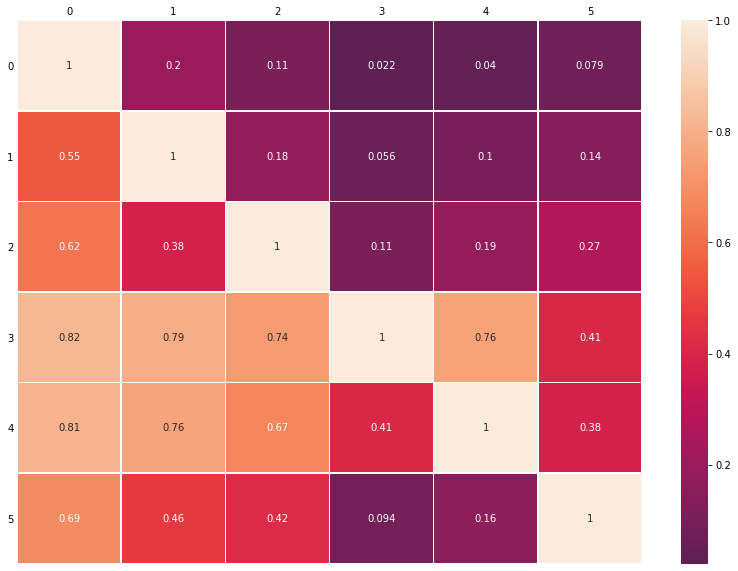

In [217]:
plt.figure(figsize=(14,10))

colormap = sns.cm.rocket
ax = sns.heatmap(np.array(score_2_2gram), annot=True,  linewidths=.5, cmap=colormap, center=0.35)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.tick_params(length=0)
plt.show()

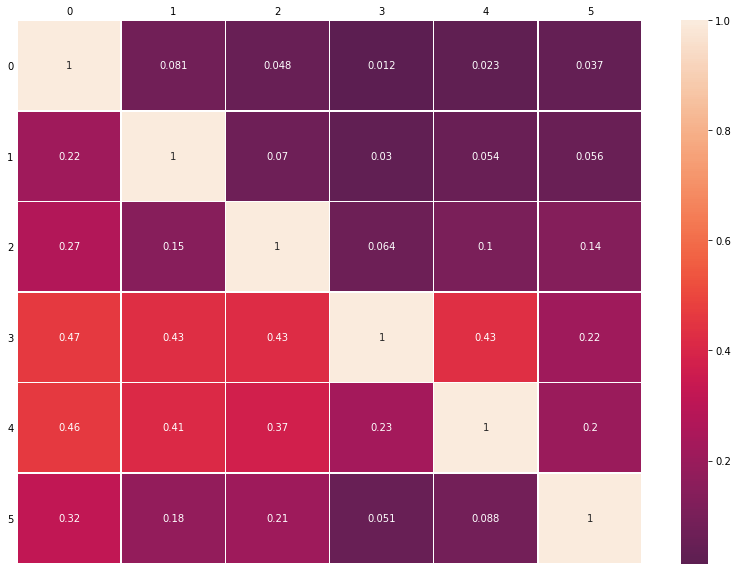

In [218]:
plt.figure(figsize=(14,10))

colormap = sns.cm.rocket
ax = sns.heatmap(np.array(score_2_3gram), annot=True,  linewidths=.5, cmap=colormap, center=0.35)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.tick_params(length=0)
plt.show()

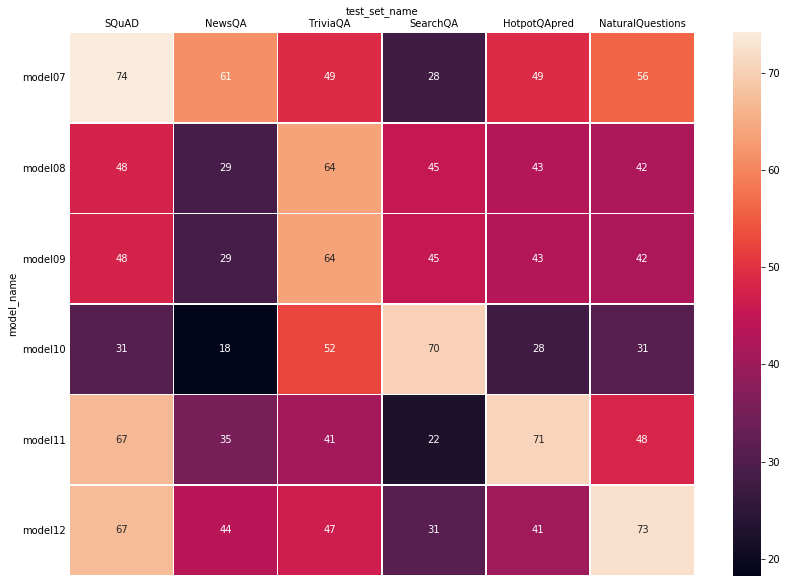

In [219]:
models_parent_dir='/data/distribution_shift/models'

results_csv = models_parent_dir+"/model_scores.csv"

scores_df = pd.read_csv(results_csv)
    
plt.figure(figsize=(14,10))

scores = scores_df.loc[scores_df['model_name'].isin(['model07', 'model08', 'model09', 'model10', 'model11', 'model12'])].pivot("model_name", "test_set_name", "f1")

# model_order=['SQuAD', 'NewsQA', 'TriviaQA', 'SearchQA', 'HotpotQApred', 'NaturalQuestions', 'BioASQ', 'DROP', 'DuoRC', 'RACE', 'RelationExtraction', 'TextbookQA']
model_order=['SQuAD', 'NewsQA', 'TriviaQA', 'SearchQA', 'HotpotQApred', 'NaturalQuestions']

# scores.loc[scores['model_name'] == 'model07']

ax = sns.heatmap(scores[model_order], annot=True,  linewidths=.5)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.tick_params(length=0)
plt.show()

In [220]:
scores_list = scores[model_order].values.tolist()
scores_list_flat = [j for sub in scores_list for j in sub]


score_1_2gram_flat = [j for sub in score_1_2gram for j in sub]
score_2_2gram_flat = [j for sub in score_2_2gram for j in sub]
source_sum_2gram_flat = [j for sub in source_sum_2gram for j in sub]
common_sum_2gram_flat = [j for sub in common_sum_2gram for j in sub]

score_1_3gram_flat = [j for sub in score_1_3gram for j in sub]
score_2_3gram_flat = [j for sub in score_2_3gram for j in sub]
source_sum_3gram_flat = [j for sub in source_sum_3gram for j in sub]
common_sum_3gram_flat = [j for sub in common_sum_3gram for j in sub]

x_pre = [score_2_2gram_flat] + [source_sum_2gram_flat] + [common_sum_2gram_flat]

In [155]:
print(x_pre)


[[1.0, 0.20348918071060318, 0.10958517935222419, 0.021670129031811435, 0.039797882068071985, 0.07855857117233857, 0.5474089325979907, 1.0, 0.18197517536841423, 0.05614777636714809, 0.10099733434405524, 0.14250097917558907, 0.6209224080831726, 0.3832896571563748, 1.0, 0.11057256631624554, 0.18623702684351656, 0.2703888150694208, 0.8208283916758704, 0.7905928409505616, 0.7391843299054601, 1.0, 0.7590844526618192, 0.4079639004498717, 0.8099825278181838, 0.7641085245515787, 0.6689539299576088, 0.40786356775769933, 1.0, 0.3823677929931293, 0.6862985876353235, 0.46277173040872344, 0.4168912130641312, 0.09409149998151116, 0.16412893201339013, 1.0], [2501691, 2501691, 2501691, 2501691, 2501691, 2501691, 6729832, 6729832, 6729832, 6729832, 6729832, 6729832, 14174873, 14174873, 14174873, 14174873, 14174873, 14174873, 94759888, 94759888, 94759888, 94759888, 94759888, 94759888, 50915423, 50915423, 50915423, 50915423, 50915423, 50915423, 21855120, 21855120, 21855120, 21855120, 21855120, 21855120], 

In [232]:
import numpy as np
from sklearn.linear_model import LinearRegression

x = []
y = []
for x1,x2,x3,x4,y1 in zip(score_1_3gram_flat,
                          score_2_3gram_flat, 
                          source_sum_3gram_flat, 
                          common_sum_3gram_flat, 
                          scores_list_flat):
    if x1 != x2 and x1 != 1.0:
#         print([x1,x2,x3,x4])
        x.append([x1,x2,x3,x4])
        y.append(y1)
        

# x = np.reshape(common_sum_2gram_flat, [3,12])
# x = x_pre

# y = scores_list_flat

model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)

r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.36046294833198755


In [234]:
import statsmodels.api as sm
# X = sm.add_constant(X.ravel())

results = sm.OLS(y,x).fit()
y_pred2 = results.predict(x)
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.876
Model:                            OLS   Adj. R-squared (uncentered):              0.857
Method:                 Least Squares   F-statistic:                              45.80
Date:                Sun, 12 Jul 2020   Prob (F-statistic):                    2.09e-11
Time:                        22:09:22   Log-Likelihood:                         -125.44
No. Observations:                  30   AIC:                                      258.9
Df Residuals:                      26   BIC:                                      264.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           123.6061     16.160      7.649      0.000      90.390     156.823
x2           164.3765     31.014      5.300      0.000     100.625     228.128
x3         -2.568e-07   1.84e-07     -1.394      0.175   -6.36e-07    1.22e-07
x4         -2.097e-06   7.78e-07     -2.695      0.012    -3.7e-06   -4.98e-07
==============================================================================
Omnibus:                        0.067   Durbin-Watson:                   1.554
Prob(Omnibus):                  0.967   Jarque-Bera (JB):                0.183
Skew:                          -0.099   Prob(JB):                        0.913
Kurtosis:                       2.672   Cond. No.                     4.58e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.58e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [235]:
for orig, pred in zip(y, y_pred):
    print("Orig: {} Pred: {} Diff: {}".format(orig, pred, abs(orig-pred)))

Orig: 61.23760646831118 Pred: 48.75157750311581 Diff: 12.486028965195366
Orig: 49.14853649567206 Pred: 47.03337312330156 Diff: 2.1151633723705032
Orig: 27.79744437013751 Pred: 44.023169846479036 Diff: 16.225725476341527
Orig: 49.131653777953 Pred: 44.44453960965531 Diff: 4.68711416829769
Orig: 55.972728438073084 Pred: 46.19479752660438 Diff: 9.777930911468701
Orig: 47.77573801643766 Pred: 53.75590206364494 Diff: 5.980164047207282
Orig: 63.87607581924552 Pred: 47.386197402708405 Diff: 16.489878416537117
Orig: 45.34307385663825 Pred: 42.890511904383956 Diff: 2.4525619522542925
Orig: 43.25315430543039 Pred: 43.984224052828964 Diff: 0.7310697473985712
Orig: 42.14957216150568 Pred: 46.484084946011585 Diff: 4.334512784505904
Orig: 47.77573801643766 Pred: 53.883691384588204 Diff: 6.107953368150547
Orig: 28.707356326514763 Pred: 48.7751572492852 Diff: 20.067800922770438
Orig: 45.34307385663825 Pred: 40.40431775800879 Diff: 4.938756098629462
Orig: 43.25315430543039 Pred: 42.707449396339754 Diff